In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs): #kwargs means any type of argument, can be optional. Here, the first three inputs are mandatory.
    """
    Runs a back test (simulation) of allocating between two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs) #this is another function
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

The Simplest Allocator - Fixed Mix
The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

run these functions (saved to erk module) for the 10 year and 30 year bond mix

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035957,0.003601,0.02627,2.973864,-0.001253,-0.000778,1.61006,0.0


In [5]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [6]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7) #70/30 mixed portfolio of equities and bonds
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.057743,0.004599,0.164281,2.676484,-0.002569,-0.002277,5.870726,0.0


In [7]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.041130,0.109373,0.048524,2.576037,0.047694,0.058254,0.098906,-0.247646
1,0.085658,0.123585,0.481856,3.145600,0.045818,0.055601,0.438199,-0.166427
2,0.040050,0.100122,-0.001717,2.587903,0.043905,0.051648,0.097570,-0.187556
3,0.065049,0.113820,0.113706,3.340977,0.046732,0.063392,0.299569,-0.194225
4,0.023895,0.108457,-0.605816,3.624888,0.053583,0.075506,-0.054919,-0.227633


In [8]:
summaries.mean()

Annualized Return          0.052304
Annualized Vol             0.107285
Skewness                  -0.017908
Kurtosis                   2.959572
Cornish-Fisher VaR (5%)    0.046191
Historic CVaR (5%)         0.058523
Sharpe Ratio               0.202737
Max Drawdown              -0.213210
dtype: float64

However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

The basic idea is to measure the distribution of terminal values across all scenarios.

See erk module for terminal_values and termina_stats functions

In [9]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,FI,Eq,70/30
mean,1.385034,1.919226,1.750450
std,0.106691,0.933429,0.588728
p_breach,NaN,0.060000,0.016000
e_short,NaN,0.153913,0.120582
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\.venv\Lib\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
c:\Users\shantala.mukherjee\OneDrive - Invartis Consulting\Python\.venv\Lib\site-packages\seaborn\distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


<Figure size 1200x600 with 0 Axes>

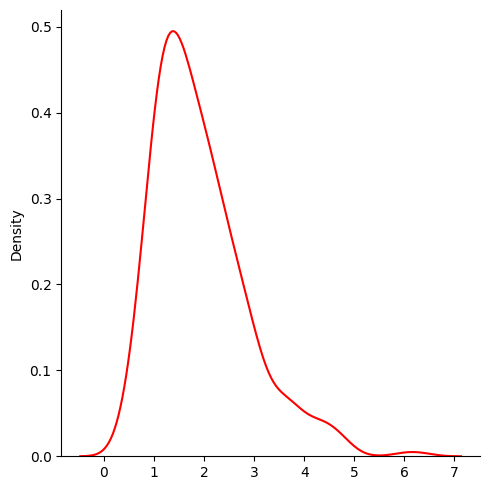

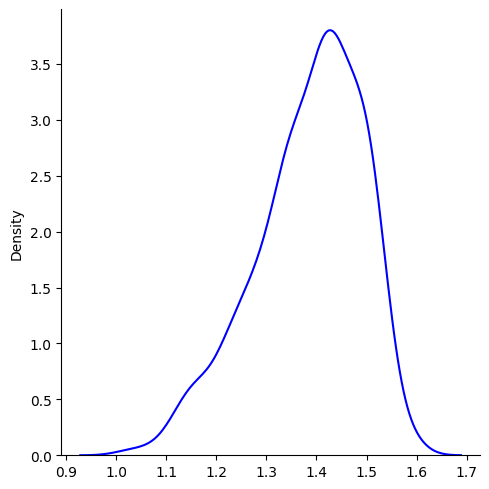

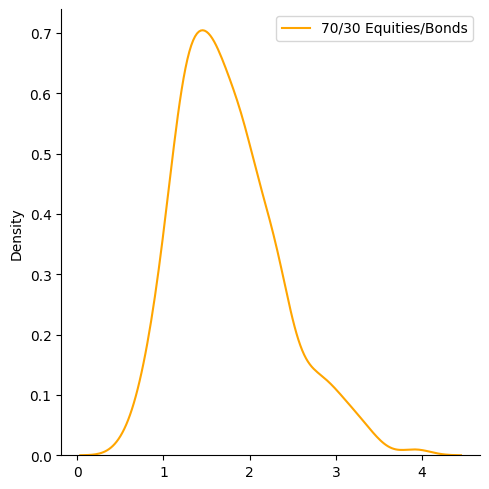

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.displot(erk.terminal_values(rets_eq), color="red", label="100% Equities", kind="kde")
sns.displot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds", kind="kde")
sns.displot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds", kind="kde")
plt.legend();

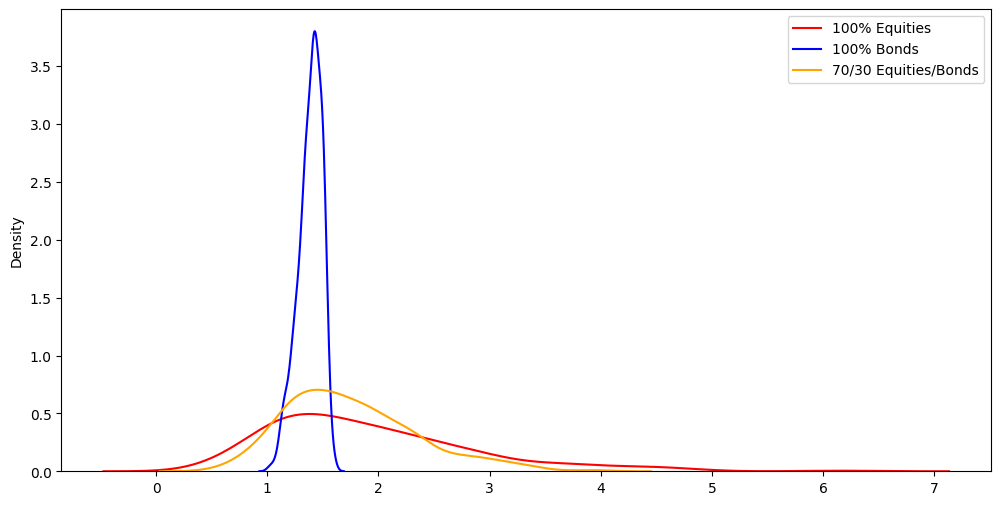

In [13]:
plt.figure(figsize=(12, 6))
sns.kdeplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.kdeplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.kdeplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

# Glide Paths for Allocation

In [14]:
# glidepath_allocator function defined in erk module
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.385034,1.919226,1.750450,1.642679
std,0.106691,0.933429,0.588728,0.424141
p_breach,NaN,0.060000,0.016000,0.008000
e_short,NaN,0.153913,0.120582,0.073480
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
